## Evaluating Inference-Time Adaptive Temperature for Improving Mathematical Reasoning in Large Language Models

## Step 1: Install Hugging Face CLI
- The Hugging Face Command Line Interface (CLI) allows you to interact with Hugging Face models and repositories directly.

- Make sure to request access to model while creating a token. Given that Gemma-2-2B-Instruct is an publicly gated model, the link below might alleviate some issues regarding access to such models.   

https://huggingface.co/docs/hub/en/models-gated


In [1]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `HF Token` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `HF Token`


## Step 2: Install Required Libraries

- Before running the code cells, ensure that all necessary Python packages are installed.


In [1]:
! pip install datasets transformers
! pip install torch
! pip install tqdm
! pip install huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Step 3: Import Libraries and Define Configuration

This section imports all the necessary libraries required for data handling, model processing, and performance monitoring. Additionally, it defines a `Config` class that encapsulates various **hyperparameters** essential for controlling the behavior and performance of our model.



#### **Note on some Hugging Face Transformers Libraries imports**


  - **`LogitsProcessorList`, `LogitsProcessor`**:
    - **Purpose**: Facilitate the modification of logits (raw model outputs) before sampling, enabling custom behaviors like temperature scaling or top-k filtering.
    - **Usage**: Used to implement adaptive entropy-based temperature scaling during text generation.

  - **`TextIteratorStreamer`**:
    - **Purpose**: Streams generated text tokens in real-time, allowing for interactive or progressive processing of generated text.
    - **Usage**: Enables the asynchronous generation and collection of text outputs without blocking the main thread.

### **Configuration**

- The `Config` class is a `NamedTuple` that encapsulates various **hyperparameters**.
- I would encourage extensive experimentation with the following hyperparameters
  - **`entropy_threshold`** : Threshold to trigger adaptive temperature (We can think of this as a high entropy zone)
  - **`max_new_tokens`**
  - **`num_samples`**
  - **`min_beta`**: Lower Bound on the beta (inverse of temeprature) parameter


In [34]:
import logging
import math
from typing import NamedTuple, Tuple, Optional, Dict, List, Any
from tqdm.notebook import tqdm
import numpy as np
from threading import Thread
from datasets import load_dataset
import pandas as pd
from statistics import mean, stdev

import torch
import torch.nn.functional as F
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    LogitsProcessorList,
    LogitsProcessor,
    TextIteratorStreamer
)

class Config(NamedTuple):
    model_name: str = "google/gemma-2-2b-it"
    entropy_threshold: float = 0.6
    poly_coeffs: Tuple[float, ...] = (-1.791, 4.917, -2.3, 0.481, -0.037)
    max_new_tokens: int = 500
    max_tokens: int = 2048
    top_p: float = 0.9
    top_k: int = 40
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_samples: int = 50
    min_beta: float = 0.5

## `TokenMetrics` Class

The `TokenMetrics` class is designed to **store and manage per-token generation metrics** during the text generation process.

### **Attributes**

- **`tokens`** (`List[str]`):
  - **Description**: A list that holds each token generated by the model.
  - **Purpose**: Keeps track of the sequence of tokens produced, allowing for reconstruction and analysis of the generated text.

- **`entropies`** (`List[float]`):
  - **Description**: A list that records the entropy values associated with each generated token.
  - **Purpose**: Measures the uncertainty or randomness in the model's predictions for each token, providing insights into the model's confidence during generation.

- **`betas`** (`List[float]`):
  - **Description**: A list that stores the temperature scaling factors (`beta`) applied during the generation of each token.
  - **Purpose**: Allows monitoring of how the temperature parameter influences the randomness and creativity of the generated tokens.

- **`timestamps`** (`List[float]`):
  - **Description**: A list that logs the timestamp for when each token was generated.
  - **Purpose**: Enables tracking of the generation time for each token, which can be useful for performance analysis and optimization.


In [35]:

class TokenMetrics:
    """Stores per-token generation metrics"""
    def __init__(self):
        self.tokens: List[str] = []
        self.entropies: List[float] = []
        self.betas: List[float] = []
        self.timestamps: List[float] = []

    def add_metric(self, token: str, entropy: float, beta: float, timestamp: float):
        self.tokens.append(token)
        self.entropies.append(entropy)
        self.betas.append(beta)
        self.timestamps.append(timestamp)

    def get_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame({
            'token': self.tokens,
            'entropy': self.entropies,
            'beta': self.betas,
            'timestamp': self.timestamps
        })

## `AdaptiveEntropyTemperature` Class

The `AdaptiveEntropyTemperature` class is a custom **LogitsProcessor** that dynamically adjusts the temperature scaling factor (`beta`) during the text generation process based on the entropy of the model's predictions.
### **Key Features**

- **Dynamic Temperature Adjustment**:
  - **Entropy Calculation**: Computes the entropy of the model's output probabilities to assess prediction uncertainty.
  - **Temperature Scaling**: Adjusts the inverse of temperature (`beta`) using a polynomial function when entropy exceeds a predefined threshold.

- **Metric Tracking**:
  - **`TokenMetrics` Integration**: Records detailed metrics for each generated token, including the token itself, its entropy, the applied `beta`, and a timestamp.






In [36]:

class AdaptiveEntropyTemperature(LogitsProcessor):
    def __init__(self, config: Config, tokenizer: PreTrainedTokenizer):
        self.config = config
        self.tokenizer = tokenizer
        self.current_entropy = None
        self.current_beta = None
        self.step_count = 0
        self.min_beta = config.min_beta
        self.token_metrics = TokenMetrics()


    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        # Get probabilities and compute entropy
        probs = F.softmax(scores, dim=-1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1, keepdims=True)
        self.current_entropy = entropy.item()

        if self.current_entropy > self.config.entropy_threshold:
            self.current_beta = max(np.polyval(self.config.poly_coeffs, self.current_entropy), self.min_beta)
        else:
            self.current_beta = 1.0

        # Get the latest generated token
        latest_token_id = input_ids[0, -1].item()
        latest_token = self.tokenizer.decode([latest_token_id])

        # Record metrics
        self.token_metrics.add_metric(
            token=latest_token,
            entropy=self.current_entropy,
            beta=self.current_beta,
            timestamp=pd.Timestamp.now().timestamp()
        )

        # Print token-level information
        print(f"Token [{self.step_count}]: '{latest_token}' | "
              f"Entropy: {self.current_entropy:.3f} | "
              f"Beta: {self.current_beta:.3f}")

        self.step_count += 1
        return scores * self.current_beta

    def get_generation_metrics(self) -> Dict[str, Any]:
        return {
            "token_metrics": self.token_metrics.get_dataframe(),
            "steps_taken": self.step_count,
            "final_beta": self.current_beta,
            "final_entropy": self.current_entropy,
        }


## `ModelManager` Class

The `ModelManager` class is a **context manager** designed to handle the loading and unloading of the pre-trained language model and its corresponding tokenizer.

### **Key Features**


  -  Automatically loads the specified pre-trained model and tokenizer when entering the context.
  -  Ensures that the model is moved to the CPU and properly deleted upon exiting the context, freeing up GPU memory.

  - Utilizes a `Config` object to determine parameters such as the model name, device (CPU/GPU), and other hyperparameters..

  - Implements the `__enter__` and `__exit__` methods, enabling the use for streamlined model management.



In [37]:

class ModelManager:
    def __init__(self, config: Config):
        self.config = config
        self.model: Optional[PreTrainedModel] = None
        self.tokenizer: Optional[PreTrainedTokenizer] = None

    def __enter__(self):
        print(f"Loading model {self.config.model_name} on {self.config.device}")
        self.model = AutoModelForCausalLM.from_pretrained(
            self.config.model_name,
            device_map="auto",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.model_name)

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        return self.model, self.tokenizer

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.model is not None:
            self.model = self.model.cpu()
            del self.model
            torch.cuda.empty_cache()
        if self.tokenizer is not None:
            del self.tokenizer
        self.model = None
        self.tokenizer = None

## `evaluate_answer` Function

The `evaluate_answer` function assesses the quality of generated math solutions by comparing them to ground truth answers. It performs the following operations:

1. **Extract Final Numerical Answer**:
   - **`extract_final_number`**: Parses the text to retrieve the last numerical value, ignoring symbols like `$` and `%`.

2. **Check for Solution Steps**:
   - **`has_solution_steps`**: Determines if the generated text includes step-by-step reasoning by searching for indicators such as "step", "first", "then", etc.

3. **Evaluate Numerical Accuracy**:
   - Compares the extracted numerical answer from the generated text with the ground truth, allowing a small tolerance for discrepancies.

4. **Return Evaluation Metrics**:
   - **`length`**: Number of words in the generated answer.
   - **`has_numerical_answer`**: Indicates if a numerical answer was extracted.
   - **`has_solution_steps`**: Indicates presence of step-by-step reasoning.
   - **`numerical_match`**: Boolean indicating if the numerical answers match within the tolerance.
   - **`extracted_answer`**: The numerical answer extracted from the generated text.
   - **`ground_truth_number`**: The correct numerical answer.
   - **`is_complete`**: True if both a numerical answer and solution steps are present.
   - **`overall_correct`**: True if both the numerical match and solution steps are correct.


   ### **NOTE**: This is a really janky implementation and is one of the sections of the code that need further refinement given that this could help improve the benchmarking results. I was running against deadlines and had to resort to a hackneyed implementation


In [38]:

def evaluate_answer(generated: str, ground_truth: str) -> Dict[str, Any]:
    """
    Evaluates generated math solutions against ground truth answers.
    """
    def extract_final_number(text: str) -> Optional[float]:
        """Extract the final numerical answer from text."""
        text = text.replace('$', '').replace('%', '')
        numbers = []
        for word in text.replace(',', '').split():
            try:
                numbers.append(float(word))
            except ValueError:
                continue
        return numbers[-1] if numbers else None

    def has_solution_steps(text: str) -> bool:
        """Check if the text contains step-by-step reasoning."""
        step_indicators = ['step', 'first', 'then', 'next', 'finally', '1)', '2)', '3)']
        return any(indicator in text.lower() for indicator in step_indicators)

    generated_num = extract_final_number(generated)
    ground_truth_num = extract_final_number(ground_truth)

    numerical_match = False
    if generated_num is not None and ground_truth_num is not None:
        tolerance = max(0.01 * abs(ground_truth_num), 0.01)
        numerical_match = abs(generated_num - ground_truth_num) <= tolerance

    return {
        "length": len(generated.split()),
        "has_numerical_answer": generated_num is not None,
        "has_solution_steps": has_solution_steps(generated),
        "numerical_match": numerical_match,
        "extracted_answer": generated_num,
        "ground_truth_number": ground_truth_num,
        "is_complete": generated_num is not None and has_solution_steps(generated),
        "overall_correct": numerical_match and has_solution_steps(generated)
    }


## Generation Functions

This section includes two functions, `generate_baseline` and `generate_with_adaptive_temp`, which handle text generation using the pre-trained model. The former uses standard generation settings, while the latter incorporates adaptive temperature scaling based on entropy.

### `generate_baseline`

Generates text using the baseline settings without any adaptive mechanisms.

- **Parameters**:
  - `prompt` (`str`): The input text prompt for generation.
  - `model` (`PreTrainedModel`): The pre-trained language model.
  - `tokenizer` (`PreTrainedTokenizer`): The tokenizer corresponding to the model.
  - `config` (`Config`): Configuration object containing hyperparameters.

- **Process**:
  1. Tokenizes the input prompt and moves it to the specified device.
  2. Sets up generation parameters including `max_new_tokens`, `temperature`, `top_p`, and `top_k`.
  3. Initiates text generation in a separate thread to stream output.
  4. Collects and returns the generated text.

- **Returns**:
  - `generated_text` (`str`): The text generated by the model.

### `generate_with_adaptive_temp`

Generates text with adaptive temperature scaling based on the entropy of each token prediction.

- **Parameters**:
  - `prompt` (`str`): The input text prompt for generation.
  - `model` (`PreTrainedModel`): The pre-trained language model.
  - `tokenizer` (`PreTrainedTokenizer`): The tokenizer corresponding to the model.
  - `config` (`Config`): Configuration object containing hyperparameters.

- **Process**:
  1. Tokenizes the input prompt and moves it to the specified device.
  2. Initializes the `AdaptiveEntropyTemperature` processor to adjust temperature dynamically.
  3. Sets up generation parameters including `max_new_tokens`, `top_p`, `top_k`, and the custom logits processor.
  4. Initiates text generation in a separate thread to stream output.
  5. Collects the generated text and retrieves generation metrics.
  6. Prints summary statistics such as total tokens generated, average entropy, average beta, and generation time.



In [39]:

def generate_baseline(
    prompt: str,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    config: Config
) -> str:
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=config.max_tokens
    ).to(config.device)

    streamer = TextIteratorStreamer(tokenizer)
    generation_kwargs = dict(
        **inputs,
        max_new_tokens=config.max_new_tokens,
        do_sample=True,
        temperature=1.0,
        top_p=config.top_p,
        top_k=config.top_k,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        streamer=streamer
    )

    thread = Thread(target=model.generate, kwargs=generation_kwargs)
    thread.start()

    generated_text = ""
    for text in streamer:
        generated_text += text

    return generated_text

def generate_with_adaptive_temp(
    prompt: str,
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    config: Config
) -> Tuple[str, Dict]:
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=config.max_tokens
    ).to(config.device)

    adaptive_processor = AdaptiveEntropyTemperature(config, tokenizer)
    processors = LogitsProcessorList([adaptive_processor])
    streamer = TextIteratorStreamer(tokenizer)

    generation_kwargs = dict(
        **inputs,
        max_new_tokens=config.max_new_tokens,
        do_sample=True,
        top_p=config.top_p,
        top_k=config.top_k,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        logits_processor=processors,
        output_scores=True,
        return_dict_in_generate=True,
        streamer=streamer
    )

    thread = Thread(target=model.generate, kwargs=generation_kwargs)
    thread.start()

    generated_text = ""
    for text in streamer:
        generated_text += text

    # Get detailed generation metrics
    generation_metrics = adaptive_processor.get_generation_metrics()

    # Print summary statistics
    metrics_df = generation_metrics['token_metrics']
    print("\nGeneration Summary:")
    print(f"Total tokens generated: {len(metrics_df)}")
    print(f"Average entropy: {metrics_df['entropy'].mean():.3f}")
    print(f"Average beta: {metrics_df['beta'].mean():.3f}")
    print(f"Generation time: {metrics_df['timestamp'].max() - metrics_df['timestamp'].min():.2f} seconds")

    return generated_text, generation_metrics

## Generation and Evaluation Functions

This section comprises two primary functions, `run_experiment` and `analyze_results`, which orchestrate the process of generating model outputs, evaluating their accuracy, and analyzing the overall performance.

### `run_experiment`

Generates answers for a set of math problems using both baseline and adaptive temperature methods, evaluates the generated answers against ground truth, and collects the results for further analysis.

- **Parameters**:
  - `problems` (`List[Dict]`): A list of dictionaries where each dictionary contains a `question` and its corresponding `answer`.
  - `display_outputs` (`bool`, optional): If set to `True`, the function will print the generated outputs for each problem. Defaults to `False`.

- **Returns**:
  - `List[Dict]`: A list of result dictionaries, each containing the original question, ground truth answer, baseline and adaptive generated texts, their evaluations, and additional statistics for the adaptive method.

- **Functionality**:
  1. **Configuration Initialization**:
     - Instantiates a `Config` object to access hyperparameters.
  
  2. **Model and Tokenizer Setup**:
     - Utilizes the `ModelManager` context manager to load the pre-trained model and tokenizer based on the configuration.
  
  3. **Problem Processing Loop**:
     - Iterates over each math problem using a progress bar provided by `tqdm`.
     - For each problem:
       - Constructs a prompt instructing the model to solve the problem step-by-step.
       - Generates responses using both the baseline and adaptive temperature methods.
       - Evaluates each generated response against the ground truth answer using the `evaluate_answer` function.
       - Compiles the results into a structured dictionary and appends it to the `results` list.
       - If `display_outputs` is `True`, prints the question, ground truth, and both generated outputs for immediate inspection.
  
  4. **Error Handling**:
     - Catches and logs any exceptions that occur during the processing of individual problems, allowing the experiment to continue uninterrupted.

### `analyze_results`

Analyzes the collected experiment results by aggregating various performance metrics for both baseline and adaptive generation methods, and prints a comprehensive summary of the findings.

- **Parameters**:
  - `results` (`List[Dict]`): The list of result dictionaries returned by the `run_experiment` function.
  - `config` (`Config`): Configuration object containing hyperparameters (currently unused but can be leveraged for extended analysis).

- **Returns**:
  - `None`: The function outputs the analysis directly to the console.

- **Functionality**:
  1. **Metric Initialization**:
     - Sets up dictionaries to accumulate metrics for both baseline and adaptive methods, including counts of numerical matches, presence of solution steps, completeness of solutions, overall correctness, response lengths, and adaptive-specific statistics like final `beta` values and entropies.
  
  2. **Metrics Aggregation**:
     - Iterates through each result:
       - Extracts and aggregates evaluation metrics for the baseline method.
       - Extracts and aggregates evaluation metrics and adaptive statistics for the adaptive method.
  
  3. **Performance Metrics Calculation**:
     - Calculates percentages for key metrics such as Numerical Accuracy, Presence of Solution Steps, Complete Solutions, and Overall Correctness for both baseline and adaptive methods.
  
  4. **Response Statistics**:
     - Computes average and standard deviation of response lengths for both methods.
  
  5. **Adaptive Control Statistics**:
     - Calculates average and standard deviation of the final `beta` values and entropies used in the adaptive method.
     - Determines the percentage of tokens where adaptive temperature scaling was applied (`beta` not equal to 1.0).
  
  6. **Token-Level Analysis**:
     - Aggregates token-level metrics from all adaptive generations.
     - Computes overall statistics such as total tokens generated, average entropy, average `beta`, and their respective standard deviations.
  
  7. **Output**:
     - Prints a detailed summary of all the computed metrics and statistics to provide insights into the performance differences between the baseline and adaptive generation methods.

### **Workflow Overview**

1. **Data Preparation**:
   - Use `prepare_math_problems` to load and select a subset (`num_samples`) of math problems from the GSM8K dataset.

2. **Experiment Execution**:
   - Invoke `run_experiment` to generate answers using both baseline and adaptive temperature methods.
   - Collect evaluations comparing the generated answers against ground truth.

3. **Result Analysis**:
   - Utilize `analyze_results` to compute and display performance metrics, helping to assess the effectiveness of the adaptive temperature approach.




In [40]:

def prepare_math_problems(config: Config) -> List[Dict[str, str]]:
    dataset = load_dataset("gsm8k", "main")
    problems = []

    for item in dataset['train'].select(range(config.num_samples)):
        problems.append({
            'question': item['question'],
            'answer': item['answer']
        })

    return problems


def run_experiment(problems: List[Dict], display_outputs: bool = False) -> List[Dict]:
    config = Config()
    results = []

    with ModelManager(config) as (model, tokenizer):
        for problem in tqdm(problems, desc="Processing problems"):
            try:
                prompt = (f"Solve this step by step:\n{problem['question']}\n"
                         f"Let's solve this step by step:")

                baseline = generate_baseline(prompt, model, tokenizer, config)
                adaptive_output, stats = generate_with_adaptive_temp(prompt, model, tokenizer, config)

                result = {
                    'question': problem['question'],
                    'ground_truth': {
                        'answer': problem['answer']
                    },
                    'baseline': {
                        'text': baseline,
                        'evaluation': evaluate_answer(baseline, problem['answer'])
                    },
                    'adaptive': {
                        'text': adaptive_output,
                        'evaluation': evaluate_answer(adaptive_output, problem['answer']),
                        'stats': stats
                    }
                }
                results.append(result)

                if display_outputs:
                    print(f"\nQuestion: {problem['question']}")
                    print(f"\nGround Truth: {problem['answer']}")
                    print("\nBaseline output:")
                    print(baseline)
                    print("\nAdaptive output:")
                    print(adaptive_output)
                    print("-" * 80)

            except Exception as e:
                logging.error(f"Error processing problem: {str(e)}")
                continue

    return results

def analyze_results(results: List[Dict], config: Config) -> None:
    print("\nDetailed Analysis Summary:")

    metrics = {
        'baseline': {
            'numerical_matches': 0,
            'has_steps': 0,
            'complete_solutions': 0,
            'overall_correct': 0,
            'lengths': []
        },
        'adaptive': {
            'numerical_matches': 0,
            'has_steps': 0,
            'complete_solutions': 0,
            'overall_correct': 0,
            'lengths': [],
            'final_betas': [],
            'final_entropies': []
        }
    }

    # Collect metrics
    for result in results:
        baseline_eval = result['baseline']['evaluation']
        metrics['baseline']['numerical_matches'] += baseline_eval['numerical_match']
        metrics['baseline']['has_steps'] += baseline_eval['has_solution_steps']
        metrics['baseline']['complete_solutions'] += baseline_eval['is_complete']
        metrics['baseline']['overall_correct'] += baseline_eval['overall_correct']
        metrics['baseline']['lengths'].append(baseline_eval['length'])

        adaptive_eval = result['adaptive']['evaluation']
        metrics['adaptive']['numerical_matches'] += adaptive_eval['numerical_match']
        metrics['adaptive']['has_steps'] += adaptive_eval['has_solution_steps']
        metrics['adaptive']['complete_solutions'] += adaptive_eval['is_complete']
        metrics['adaptive']['overall_correct'] += adaptive_eval['overall_correct']
        metrics['adaptive']['lengths'].append(adaptive_eval['length'])
        metrics['adaptive']['final_betas'].append(result['adaptive']['stats']['final_beta'])
        metrics['adaptive']['final_entropies'].append(result['adaptive']['stats']['final_entropy'])

    total = len(results)

    # Print performance metrics
    print("\nPerformance Metrics:")
    print(f"{'Metric':<25} {'Baseline':<15} {'Adaptive':<15}")
    print("-" * 55)

    metrics_to_report = [
        ('Numerical Accuracy', 'numerical_matches'),
        ('Has Solution Steps', 'has_steps'),
        ('Complete Solutions', 'complete_solutions'),
        ('Overall Correct', 'overall_correct')
    ]

    for metric_name, metric_key in metrics_to_report:
        baseline_pct = (metrics['baseline'][metric_key] / total) * 100
        adaptive_pct = (metrics['adaptive'][metric_key] / total) * 100
        print(f"{metric_name:<25} {baseline_pct:>6.1f}%{' '*8} {adaptive_pct:>6.1f}%")

    # Print response statistics
    print("\nResponse Statistics:")
    print(f"{'Statistic':<25} {'Baseline':<15} {'Adaptive':<15}")
    print("-" * 55)

    bl_lengths = metrics['baseline']['lengths']
    ad_lengths = metrics['adaptive']['lengths']
    print(f"Avg Response Length{' '*8} {mean(bl_lengths):>6.1f}{' '*8} {mean(ad_lengths):>6.1f}")
    print(f"StdDev Length{' '*13} {stdev(bl_lengths):>6.1f}{' '*8} {stdev(ad_lengths):>6.1f}")

    # Print adaptive-specific metrics
    print("\nAdaptive Control Statistics:")
    print(f"Average Final Beta: {mean(metrics['adaptive']['final_betas']):.3f}")
    print(f"Average Final Entropy: {mean(metrics['adaptive']['final_entropies']):.3f}")
    print(f"Beta StdDev: {stdev(metrics['adaptive']['final_betas']):.3f}")
    print(f"Entropy StdDev: {stdev(metrics['adaptive']['final_entropies']):.3f}")

    # Add token-level analysis
    print("\nToken-Level Analysis:")
    all_token_metrics = []

    for result in results:
        if 'adaptive' in result and 'stats' in result['adaptive']:
            if 'token_metrics' in result['adaptive']['stats']:
                metrics = result['adaptive']['stats']['token_metrics']
                all_token_metrics.append(metrics)

    if all_token_metrics:
        combined_metrics = pd.concat(all_token_metrics)
        print(f"Total tokens across all generations: {len(combined_metrics)}")
        print(f"Average token entropy: {combined_metrics['entropy'].mean():.3f}")
        print(f"Average token beta: {combined_metrics['beta'].mean():.3f}")
        print(f"Entropy std dev: {combined_metrics['entropy'].std():.3f}")
        print(f"Beta std dev: {combined_metrics['beta'].std():.3f}")


        num_tokens = len(combined_metrics)
        num_adaptive_tokens = (combined_metrics['beta']!= 1.0).sum()
        precentage_adaptive = (num_adaptive_tokens / num_tokens) * 100

        print(f"Number of adaptive tokens: {num_adaptive_tokens} "
              f"out of {num_tokens} ({precentage_adaptive:.2f}%)")

## `main` Function


### **Workflow Steps**

1. **Configure Logging**:
   - Initializes the logging system to capture informational messages and above, facilitating monitoring and debugging.

2. **Initialize Configuration**:
   - Creates a `Config` object that holds all necessary hyperparameters and settings for the experiment.

3. **Prepare Math Problems**:
   - Prints a message indicating the start of math problem preparation.
   - Calls `prepare_math_problems(config)` to load and select a specified number of math problems from the GSM8K dataset based on the configuration.

4. **Run Experiment**:
   - Prints a message indicating the commencement of the experiment.
   - Executes `run_experiment(problems, display_outputs=True)` to generate answers using both baseline and adaptive temperature methods, and evaluates their accuracy against ground truth answers.

5. **Analyze Results**:
   - Prints a message indicating the start of result analysis.
   - Invokes `analyze_results(results, config)` to aggregate and display performance metrics, comparing the effectiveness of baseline and adaptive generation approaches.

6. **Save Results to File**:
   - Generates a timestamp to uniquely identify the results file.
   - Converts the results list into a Pandas DataFrame.
   - Saves the DataFrame as a JSON file named `math_evaluation_results_<timestamp>.json`.
   - Prints a confirmation message indicating where the results have been saved.




#### **NOTES**:
- The per-token metrics are printed at the end of the logs. Apologies for this ordeal.  
- The logs/outputs in the next cell are really long and the per-token temperature adaption unfortunately does underperfroms the baseline model on a sample size of 200 from the GSM8K benchmark in this inference run.
- It is still worth noting that in some previous training runs on a samller sample size of 50, it did outperform the baseline model.
- Going through these logs might be mildy interesting . I encourage the reader to parse through some of the samples to see the difference in generation patterns between the tokens generated by the baseline and the adaptive temperature.   

#### **Speculative Reasons for underperformance**
- **Benchmark Leakage into the training data**
- This is a easy answer but the model does need more careful tuning of `beta` bounds. Stability analysis and gradient analysis could be one of the approaches.
- The current entropy control method from the "Softmax is not enough" paper might be sub-optimal.
- The coefficients of the polynomial control function drawn direclty from the paper might need revision.  
- **The paper mentions that this adaption comes in handy when faced with longer context lengths and length of the GSMK samples falls short in comparison.**



### **Future Directions**
- Looking at higher moments of entropy like varentropy and skewness
- Constructing control functions that are more interpretable
- More thorough per-token analysis of entropy and beta functions  
-

In [41]:

def main():
    logging.basicConfig(level=logging.INFO)
    config = Config()  # Can experiment here with parameter values and sample sizes

    print("Preparing math problems...")
    problems = prepare_math_problems(config)

    print("Running experiment...")
    results = run_experiment(problems, display_outputs=True)

    print("Analyzing results...")
    analyze_results(results, config)

    # Save results to file
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    results_df = pd.DataFrame(results)
    results_df.to_json(f"math_evaluation_results_{timestamp}.json")
    print(f"\nResults saved to math_evaluation_results_{timestamp}.json")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")
        raise




Preparing math problems...
Running experiment...
Loading model google/gemma-2-2b-it on cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing problems:   0%|          | 0/50 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Token [119]: '0' | Entropy: 0.095 | Beta: 1.000
Token [120]: '%' | Entropy: 0.073 | Beta: 1.000
Token [121]: ':**' | Entropy: 0.135 | Beta: 1.000
Token [122]: '

' | Entropy: 0.005 | Beta: 1.000
Token [123]: '*' | Entropy: 0.154 | Beta: 1.000
Token [124]: ' Bill' | Entropy: 0.014 | Beta: 1.000
Token [125]: ' and' | Entropy: 0.005 | Beta: 1.000
Token [126]: ' Dale' | Entropy: 0.157 | Beta: 1.000
Token [127]: ' eat' | Entropy: 0.043 | Beta: 1.000
Token [128]: ' ' | Entropy: 0.011 | Beta: 1.000
Token [129]: '5' | Entropy: 0.001 | Beta: 1.000
Token [130]: '0' | Entropy: 0.044 | Beta: 1.000
Token [131]: '%' | Entropy: 0.039 | Beta: 1.000
Token [132]: ' of' | Entropy: 0.640 | Beta: 0.500
Token [133]: ' the' | Entropy: 0.062 | Beta: 1.000
Token [134]: ' pizzas' | Entropy: 0.217 | Beta: 1.000
Token [135]: '.' | Entropy: 0.606 | Beta: 0.500
Token [136]: '
' | Entropy: 0.005 | Beta: 1.000
Token [137]: '*' | Entropy: 0.222 | Beta: 1.000
Token [13

Loaded 50 samples

Basic Stats:
Total tokens: 9792
Numeric tokens: 1747 (17.8%)
Adaptive tokens: 2600 (26.6%)

Adaptive Tokens Breakdown:
Numeric tokens: 125 (4.8%)
String tokens: 2475 (95.2%)


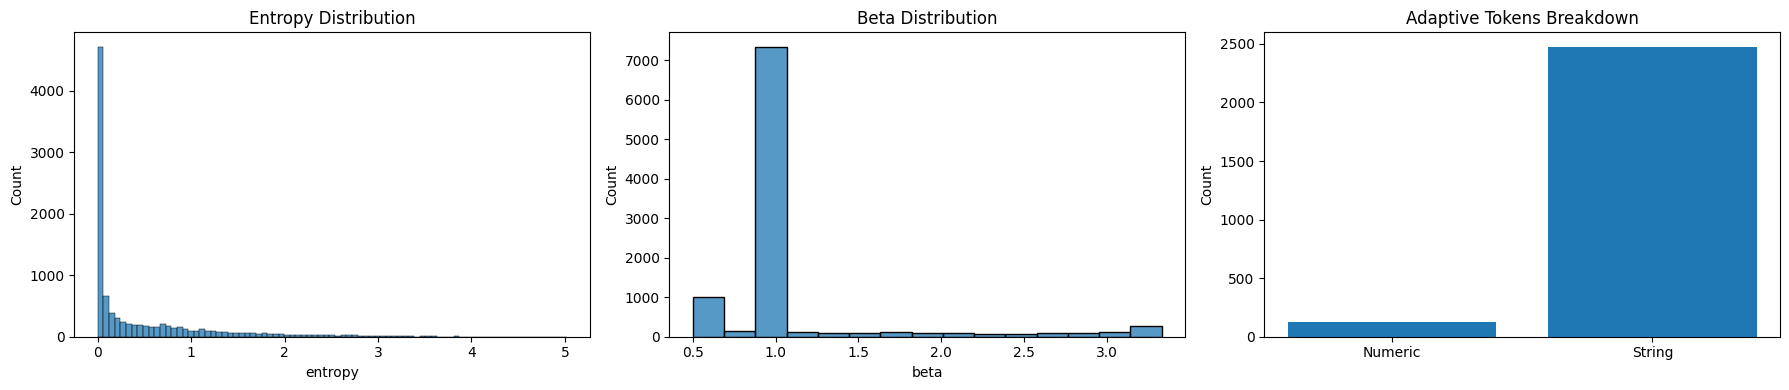

In [43]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_token_metrics(filename: str):
    """
    Minimal analysis of token metrics from experiment results
    """
    # Load data
    df = pd.read_json(filename)
    print(f"Loaded {len(df)} samples")

    # Extract and combine token metrics
    all_metrics = []
    for _, row in df.iterrows():
        try:
            metrics = row['adaptive']['stats']['token_metrics']
            metrics_df = pd.DataFrame(metrics)
            all_metrics.append(metrics_df)
        except Exception as e:
            print(f"Error extracting metrics: {e}")
            continue

    if not all_metrics:
        return None

    # Combine all metrics
    combined_df = pd.concat(all_metrics, ignore_index=True)

    # Classify tokens
    combined_df['is_numeric'] = combined_df['token'].apply(
        lambda x: bool(re.match(r'^-?\d*\.?\d+$', str(x).strip()))
    )
    combined_df['is_adaptive'] = combined_df['beta'] != 1.0

    # Basic stats
    stats = {
        'total_tokens': len(combined_df),
        'numeric_tokens': combined_df['is_numeric'].sum(),
        'adaptive_tokens': combined_df['is_adaptive'].sum(),
        'entropy': {
            'mean': combined_df['entropy'].mean(),
            'std': combined_df['entropy'].std()
        },
        'beta': {
            'mean': combined_df['beta'].mean(),
            'std': combined_df['beta'].std()
        }
    }

    # Analyze adaptive tokens breakdown
    adaptive_df = combined_df[combined_df['is_adaptive']]
    adaptive_numeric = adaptive_df['is_numeric'].sum()
    adaptive_string = len(adaptive_df) - adaptive_numeric

    stats['adaptive_breakdown'] = {
        'numeric_tokens': adaptive_numeric,
        'string_tokens': adaptive_string,
        'numeric_percentage': (adaptive_numeric / len(adaptive_df) * 100),
        'string_percentage': (adaptive_string / len(adaptive_df) * 100)
    }

    # Print analysis
    print("\nBasic Stats:")
    print(f"Total tokens: {stats['total_tokens']}")
    print(f"Numeric tokens: {stats['numeric_tokens']} ({stats['numeric_tokens']/stats['total_tokens']*100:.1f}%)")
    print(f"Adaptive tokens: {stats['adaptive_tokens']} ({stats['adaptive_tokens']/stats['total_tokens']*100:.1f}%)")

    print("\nAdaptive Tokens Breakdown:")
    print(f"Numeric tokens: {stats['adaptive_breakdown']['numeric_tokens']} ({stats['adaptive_breakdown']['numeric_percentage']:.1f}%)")
    print(f"String tokens: {stats['adaptive_breakdown']['string_tokens']} ({stats['adaptive_breakdown']['string_percentage']:.1f}%)")

    # Plot distributions
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    # Entropy distribution
    sns.histplot(data=combined_df, x='entropy', ax=ax1)
    ax1.set_title('Entropy Distribution')

    # Beta distribution
    sns.histplot(data=combined_df, x='beta', ax=ax2)
    ax2.set_title('Beta Distribution')

    # Adaptive tokens breakdown
    adaptive_counts = [adaptive_numeric, adaptive_string]
    ax3.bar(['Numeric', 'String'], adaptive_counts)
    ax3.set_title('Adaptive Tokens Breakdown')
    ax3.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    return combined_df, stats

if __name__ == "__main__":
    filename = "math_evaluation_results_20241220_194151.json"
    df, stats = analyze_token_metrics(filename)